# Importaciones

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Agregamos modelos de ML
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


# Preprocesamiento y prueba de modelos

# Función de Ganancia y Probabilidad de Corte


In [125]:
# Lectura del dataframe
df = pd.read_csv('datasets/dptos_entrenamiento.csv')


In [126]:
# El id es el indice del dataframe
df.set_index('id', inplace=True)

In [127]:
# mostramos los datos
print("Datos de Entrenamiento:", df.shape)
df.head()

Datos de Entrenamiento: (76984, 20)


,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price_period,title,paga_comision
id,,,,,,,,,,,,,,,,,,,,
RDfa+E7upD0n5pptEfHdMg==,Propiedad,2020-01-08,2020-01-11,2020-01-08,-37.999860,-57.555031,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Venta depto dos ambientes con frente abierto,no paga
mL0EoZeEqENVokwugUrtow==,Propiedad,2020-01-17,2020-01-21,2020-01-17,-34.566363,-58.438766,Argentina,Capital Federal,Palermo,NaN,NaN,NaN,4.0,3.0,1.0,81.0,75.0,NaN,VENTA 4 AMBIENTES C COCHERA FIJA MUY LUMINOSO,paga
hOZOY5Bo9FzB3IR8V6TtiA==,Propiedad,2019-11-15,9999-12-31,2019-11-15,-37.106865,-56.862300,Argentina,Buenos Aires Costa Atlántica,Pinamar,NaN,NaN,NaN,1.0,NaN,1.0,30.0,30.0,NaN,Monoambiente con entrepiso-A 150 mts de Av- Shaw-,no paga
JKfw+/BUerJ7cNjors3UBQ==,Propiedad,2019-07-14,9999-12-31,2019-07-14,NaN,NaN,Uruguay,Montevideo,NaN,NaN,NaN,NaN,3.0,2.0,1.0,62.0,54.0,Mensual,DEPARTAMENTO EN VENTA,no paga
SBDKF7R+J2C+n4gWm4JrOw==,Propiedad,2020-02-10,2020-04-28,2020-02-10,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,General San Martín,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,Departamento 3 ambientes a estrenar. Oportunid...,no paga


In [128]:
# Encodear la variable paga_comision
encoder = OrdinalEncoder()
df['paga_comision_encoded'] = encoder.fit_transform(df[['paga_comision']])
df.drop(columns=['paga_comision'], inplace=True)

In [129]:
df['paga_comision_encoded'].astype('int64')

id
RDfa+E7upD0n5pptEfHdMg==    0
mL0EoZeEqENVokwugUrtow==    1
hOZOY5Bo9FzB3IR8V6TtiA==    0
JKfw+/BUerJ7cNjors3UBQ==    0
SBDKF7R+J2C+n4gWm4JrOw==    0
                           ..
SJ10BUgrdEGcpN625rUnvQ==    0
QRvbcLYpdFrsjDoarhQRxQ==    0
149re/PCUyrmtsbpa2SAOg==    0
W6mebjf8pbvzxLhmhLYiCQ==    0
5UlIUMHlRN2N2ChpjTMy6g==    0
Name: paga_comision_encoded, Length: 76984, dtype: int64

In [130]:
columnas_numericas = ['surface_total', 'rooms', 'bathrooms']

In [131]:
# Hacemos el Split 70-30 para train-test
X = df.drop(columns="paga_comision_encoded")
y = df["paga_comision_encoded"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=54)

In [132]:
def evaluar_modelo(pipeline, X_train, X_test, y_train, y_test, nombre_modelo="Modelo"):
    """
    Evalúa un pipeline de clasificación y muestra métricas completas.
    
    Parámetros:
    -----------
    pipeline : sklearn.pipeline.Pipeline
        Pipeline entrenado a evaluar
    X_train : pd.DataFrame
        Datos de entrenamiento
    X_test : pd.DataFrame
        Datos de test
    y_train : pd.Series
        Target de entrenamiento
    y_test : pd.Series
        Target de test
    nombre_modelo : str, opcional
        Nombre del modelo para los títulos
    
    Retorna:
    --------
    dict : Diccionario con las métricas principales
    """
    from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                                  classification_report, accuracy_score,
                                  precision_score, recall_score, f1_score)
    import matplotlib.pyplot as plt
    
    # Hacer predicciones
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    
    # Calcular métricas
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average='weighted')
    recall = recall_score(y_test, y_pred_test, average='weighted')
    f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    # Imprimir resultados
    print("=" * 70)
    print(f"EVALUACIÓN: {nombre_modelo}")
    print("=" * 70)
    print(f"Accuracy en Train:        {acc_train:.4f}")
    print(f"Accuracy en Test:         {acc_test:.4f}")
    print(f"Diferencia (Overfitting): {acc_train - acc_test:.4f}")
    print(f"\nPrecision (weighted):     {precision:.4f}")
    print(f"Recall (weighted):        {recall:.4f}")
    print(f"F1-Score (weighted):      {f1:.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_test)
    print("\n" + "=" * 70)
    print("MATRIZ DE CONFUSIÓN - TEST SET")
    print("=" * 70)
    print(cm)
    
    # Visualizar la matriz de confusión
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f'Matriz de Confusión - {nombre_modelo} (Test Set)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Reporte de clasificación
    print("\n" + "=" * 70)
    print("REPORTE DE CLASIFICACIÓN - TEST SET")
    print("=" * 70)
    print(classification_report(y_test, y_pred_test))
    
    # Información del modelo (si tiene)
    if hasattr(pipeline, 'named_steps'):
        # Buscar el clasificador en el pipeline
        for step_name, step in pipeline.named_steps.items():
            if hasattr(step, 'get_depth'):  # Es un árbol
                print("\n" + "=" * 70)
                print(f"PARÁMETROS DEL ÁRBOL ({step_name})")
                print("=" * 70)
                print(f"Max Depth (configurado): {step.max_depth}")
                print(f"Profundidad Real:        {step.get_depth()}")
                print(f"Número de Hojas:         {step.get_n_leaves()}")
                print(f"Número de Features:      {step.n_features_in_}")
            elif hasattr(step, 'n_estimators'):  # Es un Random Forest o similar
                print("\n" + "=" * 70)
                print(f"PARÁMETROS DEL ENSEMBLE ({step_name})")
                print("=" * 70)
                print(f"Número de estimadores:   {step.n_estimators}")
                print(f"Max Depth:               {step.max_depth}")
                print(f"Número de Features:      {step.n_features_in_}")
    
    # Retornar métricas en un diccionario
    return {
        'accuracy_train': acc_train,
        'accuracy_test': acc_test,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'overfitting': acc_train - acc_test,
        'confusion_matrix': cm
    }


## Enconding

In [133]:
# Pasé las transformaciones a un diccionario para hacerlas reusables.
ddtr_enc = {}
ddtr_enc["ct_oh_l1"] = ("oh_l1", OneHotEncoder(sparse_output=False, dtype=int, drop='first'), ["l1"])
ddtr_enc["ct_oh_l2"] = ("oh_l2", OneHotEncoder(sparse_output=False, dtype=int, drop='first'), ["l2"])


ct_enc = ColumnTransformer([ddtr_enc["ct_oh_l1"], 
                        ddtr_enc["ct_oh_l2"]])

In [134]:
class ColOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, encoder=None, columns=[]):
        super().__init__()
        self.encoder = encoder
        self.columns = columns        
        
    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self    
    
    def get_feature_names_out(self):
        return self.encoder.get_feature_names_out()
    
    def  transform(self, X):
        Xc = X.copy()        
        Xc.loc[:, self.encoder.get_feature_names_out()] = self.encoder.transform(Xc.loc[:,self.columns]) # A la copia, le asigno el resultado de transformar las columnas indicadas con sus nombres de columna para conservarlo
        Xc.drop(self.columns, axis=1, inplace=True)
        return Xc

## Outliers

In [135]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    """
    Transformer personalizado para manejar outliers.
    Detecta outliers usando el método IQR y los convierte en NaN.
    
    Parámetros:
    -----------
    columns : list, default=None
        Lista de columnas a procesar. Si es None, procesa todas las columnas.
    factor : float, default=1.5
        Factor multiplicador del IQR para definir los límites.
        - 1.5: detección estándar (más conservador)
        - 3.0: detección extrema (solo outliers muy alejados)
    
    Ejemplo:
    --------
    >>> # Solo procesar columnas específicas
    >>> outlier_handler = OutlierHandler(columns=['lat', 'lon'], factor=1.5)
    >>> X_transformed = outlier_handler.fit_transform(X_train)
    """
    
    def __init__(self, columns=None, factor=1.5):
        self.columns = columns
        self.factor = factor
        self.lower_bounds = {}
        self.upper_bounds = {}
        self.outlier_counts = {}
        self.columns_ = None  # Columnas que realmente se procesarán
        
    def fit(self, X, y=None):
        """
        Calcula los límites inferior y superior para cada columna.
        
        Parámetros:
        -----------
        X : pd.DataFrame o np.ndarray
            DataFrame con variables numéricas.
        y : array-like, opcional
            Target (no se usa, solo por compatibilidad sklearn).
        """
        # Convertir a DataFrame si es necesario
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        # Determinar qué columnas procesar
        if self.columns is None:
            # Si no se especifican, usar todas las columnas
            self.columns_ = X.columns.tolist()
        else:
            # Validar que las columnas existen
            missing_cols = set(self.columns) - set(X.columns)
            if missing_cols:
                raise ValueError(f"Columnas no encontradas: {missing_cols}")
            self.columns_ = self.columns
        
        # Calcular límites IQR para cada columna especificada
        for col in self.columns_:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            
            self.lower_bounds[col] = Q1 - self.factor * IQR
            self.upper_bounds[col] = Q3 + self.factor * IQR
            
            # Contar outliers para estadísticas
            outliers = ((X[col] < self.lower_bounds[col]) | 
                       (X[col] > self.upper_bounds[col]))
            self.outlier_counts[col] = outliers.sum()
        
        return self
    
    def transform(self, X):
        """
        Convierte outliers en NaN para posterior imputación.
        
        Parámetros:
        -----------
        X : pd.DataFrame o np.ndarray
            DataFrame con variables numéricas.
            
        Retorna:
        --------
        X_copy : pd.DataFrame o np.ndarray
            DataFrame con outliers convertidos a NaN.
        """
        # Convertir a DataFrame si es necesario
        is_dataframe = isinstance(X, pd.DataFrame)
        if not is_dataframe:
            X = pd.DataFrame(X)
        
        X_copy = X.copy()
        
        # Solo procesar las columnas especificadas
        for col in self.columns_:
            if col in X_copy.columns:
                # Detectar outliers (fuera de límites IQR)
                outlier_mask = (
                    (X_copy[col] < self.lower_bounds[col]) | 
                    (X_copy[col] > self.upper_bounds[col])
                )
                
                # Convertir outliers a NaN
                X_copy.loc[outlier_mask, col] = np.nan
        
        # Retornar en el mismo formato que la entrada
        return X_copy if is_dataframe else X_copy.values
    
    def get_feature_names_out(self, input_features=None):
        """
        Obtener nombres de las features de salida.
        Necesario para compatibilidad con ColumnTransformer.
        """
        if input_features is None:
            return np.array(self.columns_)
        return np.array(input_features)

## Imputaciones

In [139]:
class ColumnImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer=SimpleImputer(strategy="mean"), columns=None):
        self.imputer = imputer
        self.columns = columns

    def fit(self, X, y=None):
        # Guardar todos los nombres de columnas del DataFrame original
        self.feature_names_in_ = X.columns.tolist()
        self.imputer.fit(X[self.columns])
        return self
    
    def get_feature_names_out(self, input_features=None):
        """Devuelve todos los nombres de columnas del DataFrame original"""
        return np.array(self.feature_names_in_)
    
    def transform(self, X):
        Xc = X.copy()
        # Esto mantiene los nombres de columnas porque asignamos al DataFrame
        Xc.loc[:, self.columns] = self.imputer.transform(X[self.columns])
        return Xc

## Eliminación de columnas

In [141]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    """
    Transformer para eliminar columnas específicas de un DataFrame.
    
    Parámetros:
    -----------
    columns : list
        Lista de nombres de columnas a eliminar.
    
    Ejemplo:
    --------
    >>> dropper = ColumnDropper(columns=['col1', 'col2'])
    >>> X_transformed = dropper.fit_transform(X)
    """
    
    def __init__(self, columns):
        self.columns = columns
        self.feature_names_out_ = None  # Columnas que quedan después de eliminar

    def fit(self, X, y=None):
        """
        Calcula qué columnas quedarán después de eliminar.
        
        Parámetros:
        -----------
        X : pd.DataFrame
            DataFrame de entrada.
        y : array-like, opcional
            Target (no se usa, solo por compatibilidad sklearn).
        """
        # Validar que X es DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X debe ser un pandas DataFrame")
        
        # Validar que las columnas a eliminar existen
        missing_cols = set(self.columns) - set(X.columns)
        if missing_cols:
            raise ValueError(f"Columnas no encontradas: {missing_cols}")
        
        # Guardar las columnas que quedarán después de eliminar
        self.feature_names_out_ = [col for col in X.columns if col not in self.columns]
        
        return self   
     
    def get_feature_names_out(self, input_features=None):
        """
        Obtiene los nombres de las features después de la transformación.
        
        Parámetros:
        -----------
        input_features : array-like, opcional
            Nombres de las features de entrada. Si es None, usa las guardadas en fit.
            
        Retorna:
        --------
        feature_names : np.ndarray
            Array con los nombres de las columnas después de eliminar.
        """
        if input_features is None:
            # Usar las columnas guardadas durante fit
            if self.feature_names_out_ is None:
                raise ValueError("Debe llamar a fit() antes de get_feature_names_out()")
            return np.array(self.feature_names_out_)
        else:
            # Filtrar las columnas de input_features
            return np.array([col for col in input_features if col not in self.columns])
    
    def transform(self, X):
        """
        Elimina las columnas especificadas.
        
        Parámetros:
        -----------
        X : pd.DataFrame
            DataFrame de entrada.
            
        Retorna:
        --------
        Xc : pd.DataFrame
            DataFrame sin las columnas eliminadas.
        """
        # Validar que se hizo fit
        if self.feature_names_out_ is None:
            raise ValueError("Debe llamar a fit() antes de transform()")
        
        # Crear copia y eliminar columnas
        Xc = X.copy()
        cols_to_drop = [col for col in self.columns if col in Xc.columns]
        Xc.drop(cols_to_drop, axis=1, inplace=True)
        
        return Xc

## Pipeline Arbol inicial

In [153]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

pipeline_arbol = Pipeline(
    steps=[
        ("outliers", OutlierHandler(columns=columnas_numericas, factor=1.5)),
        ("ct_enc", ColOneHot(encoder=OneHotEncoder(sparse_output=False, dtype=int, drop='first', handle_unknown='ignore'), columns=["l1", "l2"])),
        # Crear variable de price period
        ("dropper_preKNN", ColumnDropper(columns=["lat", "lon", "ad_type", "start_date", "end_date", "created_on", "price_period", "title", "l3", "l4", "l5", "l6"])),
        #KNN
        ("imputer", ColumnImputer(imputer=SimpleImputer(strategy="mean"), columns=["rooms", "surface_total", "bathrooms", "bedrooms", "surface_covered"])),
        #("dropper_final", ColumnDropper(columns=["bedrooms", "surface_covered"])),
        ("tree", DecisionTreeClassifier(
            max_depth=10,              # Profundidad máxima
            min_samples_split=20,      # Mínimo de muestras para dividir
            min_samples_leaf=5,        # Mínimo de muestras en hoja
            criterion='gini',          # Criterio de división
            max_features='sqrt',       # Número de features a considerar
            random_state=42
        ))
    ])


In [154]:
pipeline_arbol.fit(X_train, y_train)


,steps,"[('outliers', ...), ('ct_enc', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,columns,"['surface_total', 'rooms', ...]"
,factor,1.5
,encoder,OneHotEncoder..._output=False)
,columns,"['l1', 'l2']"
,categories,'auto'
,drop,'first'
,sparse_output,False


EVALUACIÓN: Árbol de Decisión
Accuracy en Train:        0.9353
Accuracy en Test:         0.9283
Diferencia (Overfitting): 0.0070

Precision (weighted):     0.9223
Recall (weighted):        0.9283
F1-Score (weighted):      0.9229

MATRIZ DE CONFUSIÓN - TEST SET
[[20011   453]
 [ 1204  1428]]


c:\Users\Gonzalo Ghiano\Desktop\2C2025\Ciencia de datos\Ejercicios\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


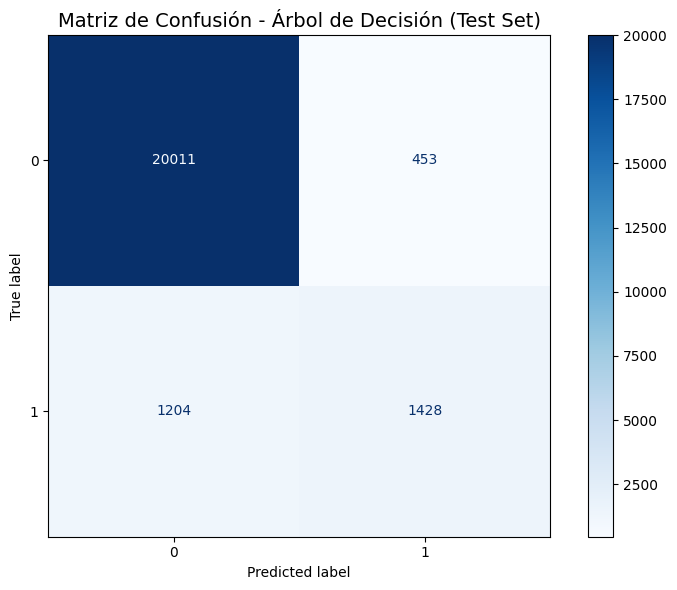


REPORTE DE CLASIFICACIÓN - TEST SET
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     20464
         1.0       0.76      0.54      0.63      2632

    accuracy                           0.93     23096
   macro avg       0.85      0.76      0.80     23096
weighted avg       0.92      0.93      0.92     23096


PARÁMETROS DEL ÁRBOL (tree)
Max Depth (configurado): 10
Profundidad Real:        10
Número de Hojas:         214
Número de Features:      37


In [155]:
# Evaluar el pipeline entrenado
metricas = evaluar_modelo(
    pipeline=pipeline_arbol,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    nombre_modelo="Árbol de Decisión"
)


Terminar el arbol
Luego sacar el subproducto de importacia de variables
Luego hacer random forest
Optimizarlos con gridsearchCV
Sacar metricas, curvas roc, curvas de validacion (train vs test en ajustes de gridsearch)
Agregar funcion de ganancia y custom treshold
Y luego seguir probando modelos, si agregamos knn o naive bayes creo que se necesita escalar las variables. (Escalar ayuda al arbol?)


- universo_total = paga_comision('paga') + paga_comision('no_paga')

Dentro de los que nosotros predecimos que **paga**:
- ganancia = **100** * paga_comision('paga') - **50** * paga_comision('no_paga')

Si descomponemos el 100 como la resta (150-50), también se podría escribir como:

- ganancia = **150** * paga_comision('paga') - **50** * paga_comision('paga') - **50** * paga_comision('no_paga')


### Cuentas

150 * paga_comision('paga') - 50 * paga_comision('paga') - 50 * paga_comision('no_paga') > 0

150 * paga_comision('paga') - 50 * (paga_comision('paga') + paga_comision('no_paga')) > 0

150 * paga_comision('paga') > 50 * (paga_comision('paga') + paga_comision('no_paga'))

paga_comision('paga') > (50/150) * (paga_comision('paga') + paga_comision('no_paga'))

paga_comision('paga') / (paga_comision('paga') + paga_comision('no_paga')) > 50/150

Prob('paga') > 0.33



In [156]:
prob_corte = float(0.33) # probabilidad de corte calculada

#Definimos la función de ganancia a utilizar para el scoring en la búsqueda:
def funcion_ganancia(clf, X, y_true):
    y_prob_pago = clf.predict_proba(X)[:, 1]

#Solo si creo que llovió tomo una acción, si decidí que llovió (segundo if) entonces digo
#Si le pegué sumo 4, si no le pegué resto 1.
#Y además decidí que si dije que no llovió no hago nada (costo 0)
    ganancia = sum([(100 if y_true[i] > 0 else -50)
                    if y_prob_pago[i]  > prob_corte
                    else 0
                    for i in range(len(y_prob_pago))])
    
    return ganancia

# Modelos con Función de ganancia

## Árbol con función de ganancia

In [160]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

pipeline_arbol_ganancia = Pipeline(
    steps=[
        ("outliers", OutlierHandler(columns=columnas_numericas, factor=1.5)),
        ("ct_enc", ColOneHot(encoder=OneHotEncoder(sparse_output=False, dtype=int, drop='first', handle_unknown='ignore'), columns=["l1", "l2"])),
        # Crear variable de price period
        ("dropper", ColumnDropper(columns=["lat", "lon", "ad_type", "start_date", "end_date", "created_on", "price_period", "title", "l3", "l4", "l5", "l6"])),
        #KNN
        ("imputer", ColumnImputer(imputer=SimpleImputer(strategy="mean"), columns=["rooms", "surface_total", "bathrooms", "bedrooms", "surface_covered"])),
        ("tree", DecisionTreeClassifier())
    ])


In [ ]:
# Parámetros para optimizar en el GridSearchCV
param_grid = {
    'tree__max_depth': [5, 7, 10, 15],
    'tree__min_samples_split': [2, 5, 10, 12],
    'tree__min_samples_leaf': [1, 2, 4, 6],
    'tree__criterion': ['gini', 'entropy', 'log_loss'],
    'tree__max_features': ["sqrt", "log2", "auto", "None"],
    'tree__random_state': [42]
}

# Crear el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_arbol,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=funcion_ganancia,
    n_jobs=-1,  # usa todos los cores disponibles
    verbose=2
)

# Entrenar
grid_search.fit(X_train, y_train)

# Mejores parámetros y score
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)

# Acceder al mejor modelo
best_pipeline = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores parámetros: {'tree__criterion': 'gini', 'tree__max_depth': 15, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 5}
Mejor score: 68470.0


EVALUACIÓN: Árbol de Decisión
Accuracy en Train:        0.9546
Accuracy en Test:         0.9341
Diferencia (Overfitting): 0.0205

Precision (weighted):     0.9301
Recall (weighted):        0.9341
F1-Score (weighted):      0.9312

MATRIZ DE CONFUSIÓN - TEST SET
[[19934   530]
 [  993  1639]]


c:\Users\Gonzalo Ghiano\Desktop\2C2025\Ciencia de datos\Ejercicios\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


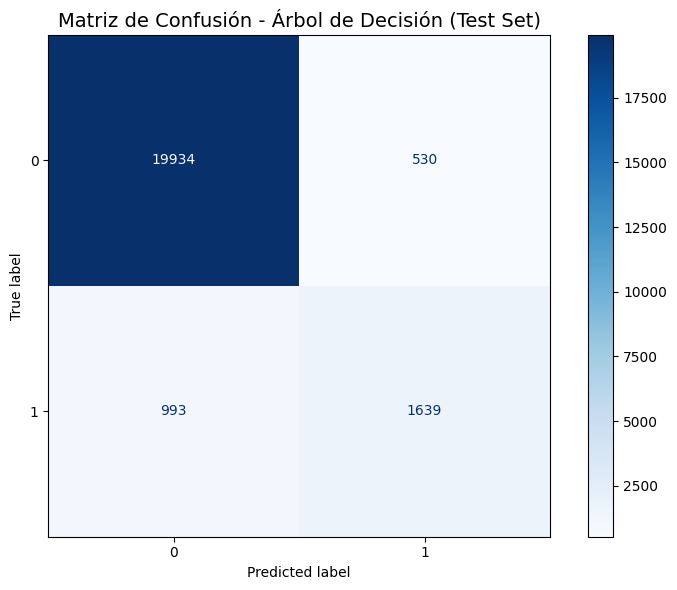


REPORTE DE CLASIFICACIÓN - TEST SET
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     20464
         1.0       0.76      0.62      0.68      2632

    accuracy                           0.93     23096
   macro avg       0.85      0.80      0.82     23096
weighted avg       0.93      0.93      0.93     23096


PARÁMETROS DEL ÁRBOL (tree)
Max Depth (configurado): 15
Profundidad Real:        15
Número de Hojas:         1318
Número de Features:      37


In [152]:
# Evaluar el pipeline entrenado
metricas = evaluar_modelo(
    pipeline=best_pipeline,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    nombre_modelo="Árbol de Decisión"
)

In [ ]:
# ===== CALCULAR GANANCIA EN TRAIN =====
ganancia_train = funcion_ganancia(pipeline_arbol, X_train, y_train)
print(f"Ganancia en Train: ${ganancia_train:,.0f}")

# ===== CALCULAR GANANCIA EN TEST =====
ganancia_test = funcion_ganancia(pipeline_arbol, X_test, y_test)
print(f"Ganancia en Test: ${ganancia_test:,.0f}")

# ===== CALCULAR GANANCIA POR OBSERVACIÓN =====
ganancia_promedio_test = ganancia_test / len(y_test)
print(f"Ganancia promedio por observación: ${ganancia_promedio_test:.2f}")

In [41]:
#Predicciones con la probabilidad de corte
y_pred = (pipeline_arbol.predict_proba(X_test)[:, 1] > prob_corte)

c:\Users\Gonzalo Ghiano\Desktop\2C2025\Ciencia de datos\Ejercicios\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95     20464
         1.0       0.63      0.69      0.66      2632

    accuracy                           0.92     23096
   macro avg       0.79      0.82      0.80     23096
weighted avg       0.92      0.92      0.92     23096



# Random Forest


In [43]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
pipeline_forest = Pipeline(
    steps=[
        ("outliers", OutlierHandler(columns=columnas_numericas, factor=2.5)),
        #("ct_enc", ColOneHot(encoder=OneHotEncoder(sparse_output=False, dtype=int, drop='first', handle_unknown='ignore'), columns=["l1"])),
        # Crear variable de price period
        ("dropper_preKNN", ColumnDropper(columns=["lat", "lon", "ad_type", "start_date", "end_date", "created_on", "price_period", "title", "l1","l2", "l3", "l4", "l5", "l6"])),
        #KNN
        ("imputer", ColumnImputer(imputer=SimpleImputer(strategy="mean"), columns=["rooms", "surface_total", "bathrooms", "bedrooms", "surface_covered"])),
        #("dropper_final", ColumnDropper(columns=["bedrooms", "surface_covered"])),
        ("forest", RandomForestClassifier())
    ])

In [121]:
pipeline_forest.fit(X_train, y_train)


,steps,"[('outliers', ...), ('dropper_preKNN', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,columns,"['surface_total', 'rooms', ...]"
,factor,2.5
,columns,"['lat', 'lon', ...]"
,imputer,SimpleImputer()
,columns,"['rooms', 'surface_total', ...]"
,missing_values,nan
,strategy,'mean'


In [123]:
# ===== CALCULAR GANANCIA EN TEST =====
ganancia_test = funcion_ganancia(pipeline_forest, X_test, y_test)
print(f"Ganancia en Test: ${ganancia_test:,.0f}")

Ganancia en Test: $147,250


C:\Users\Gonzalo Ghiano\AppData\Local\Temp\ipykernel_22824\922685401.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ganancia = sum([(100 if y_true[i] > 0 else -50)


In [97]:
#Predicciones con la probabilidad de corte
y_pred = (pipeline_forest.predict_proba(X_test)[:, 1] > prob_corte)

In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96     20464
         1.0       0.67      0.74      0.70      2632

    accuracy                           0.93     23096
   macro avg       0.82      0.85      0.83     23096
weighted avg       0.93      0.93      0.93     23096



### Random Forest con optimización de hiperparámetros

In [82]:
from sklearn.model_selection import RandomizedSearchCV

best_score = 0
param_grid = {
    'forest__criterion': ['gini', 'entropy', 'log_loss'],  # ⬅️ 'forest' es el nombre del paso
    'forest__max_depth': [3,4,6,8],
    'forest__min_samples_split': [2 ,4, 8, 10, 12],
    'forest__min_samples_leaf': [1, 2, 4, 6],
    'forest__max_features': ["sqrt"],
    'forest__n_estimators': [30,60,90,120,150,180]
}


# Crear el RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline_forest,
    param_distributions=param_grid,
    n_iter=300, # Número de combinaciones aleatorias a probar
    cv=4,
    scoring=funcion_ganancia,
    n_jobs=-1,
    verbose=2,
    random_state=42  # Opcional: para reproducibilidad
)

# Entrenar
random_search.fit(X_train, y_train)

# Mejores parámetros y score
print("Mejores parámetros:", random_search.best_params_)
print("Mejor score:", random_search.best_score_)

# Hacer predicciones con el mejor modelo
y_pred = random_search.predict(X_test)

# Acceder al mejor modelo
best_pipeline = random_search.best_estimator_

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
Mejores parámetros: {'forest__n_estimators': 120, 'forest__min_samples_split': 8, 'forest__min_samples_leaf': 2, 'forest__max_features': 'sqrt', 'forest__max_depth': 8, 'forest__criterion': 'entropy'}
Mejor score: 84937.5


In [83]:
# ===== CALCULAR GANANCIA EN TEST =====
ganancia_test = funcion_ganancia(best_pipeline, X_test, y_test)
print(f"Ganancia en Test con RandomSearch: ${ganancia_test:,.0f}")

Ganancia en Test con RandomSearch: $141,950


C:\Users\Gonzalo Ghiano\AppData\Local\Temp\ipykernel_22824\922685401.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ganancia = sum([(100 if y_true[i] > 0 else -50)


In [86]:
#Predicciones con la probabilidad de corte
y_pred = (best_pipeline.predict_proba(X_test)[:, 1] > prob_corte)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     20464
         1.0       0.68      0.71      0.69      2632

    accuracy                           0.93     23096
   macro avg       0.82      0.83      0.83     23096
weighted avg       0.93      0.93      0.93     23096

